In [2]:
!pip3 install spacy
!python3 -m spacy download en_core_web_sm
import pandas as pd
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
import re
import spacy
from time import time
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
import streamlit as st


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 3.5 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


[nltk_data] Downloading package punkt to /Users/naeeramin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/naeeramin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
scraped_data = pd.read_csv('./annotated_summaries_df.csv', encoding='iso-8859-1')
news_summary_data = pd.read_csv('./news_summary_more.csv', encoding='iso-8859-1')

In [4]:
# Creating a dataframe by combining both the data sources
combined_df = pd.DataFrame()

combined_df['article'] = pd.concat([scraped_data['article'], 
                                    news_summary_data['text']],
                                    ignore_index=True)
combined_df['summary'] = pd.concat([scraped_data['headline'], 
                                    news_summary_data['headlines']],
                                    ignore_index=True)

In [5]:
# Function to remove non-alphanumeric characters

def clean_text(col_text):
    for text in col_text:
        # Removing tabs
        text = re.sub("(\\t)", " ", str(text)).lower()
        # Removing carriage returns
        text = re.sub("(\\r)", " ", str(text)).lower()
        # Removing new line characters
        text = re.sub("(\\n)", " ", str(text)).lower()
        # Removing punctuations at the end of a word
        text = re.sub("(\.\s+)", " ", str(text)).lower()
        text = re.sub("(\-\s+)", " ", str(text)).lower()
        text = re.sub("(\:\s+)", " ", str(text)).lower()
        # Removing the following characters - <>()|&©ø"',;?~*!
        text = re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", " ", str(text)).lower()
        # Removing multiple spaces
        text = re.sub("(\s+)", " ", str(text)).lower()
        # Removing _ if it occurs more than one time consecutively
        text = re.sub(r"(__+)", " ", str(text)).lower()
        # Removing - if it occurs more than one time consecutively
        text = re.sub(r"(--+)", " ", str(text)).lower()
        # Removing ~ if it occurs more than one time consecutively
        text = re.sub(r"(~~+)", " ", str(text)).lower()
        # Removing + if it occurs more than one time consecutively
        text = re.sub(r"(\+\++)", " ", str(text)).lower()
        # Removing . if it occurs more than one time consecutively
        text = re.sub(r"(\.\.+)", " ", str(text)).lower()
        # Removing the single character hanging between any two spaces
        text = re.sub(r"(\s+.\s+)", " ", str(text)).lower()

        yield text


In [6]:
# Creating generator objects for articles and summaries for cleaning text
article_obj = clean_text(combined_df['article'])
summary_obj = clean_text(combined_df['summary'])

In [7]:
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser'])

# Getting a list of articles and summaries after processing them using the Spacy library
cleaned_articles = [str(doc) for doc in nlp.pipe(article_obj, batch_size=5000)]
cleaned_summaries = ['_START_ '+ str(doc) + ' _END_' for doc in nlp.pipe(summary_obj, batch_size=5000)]

In [8]:
print(nlp.pipe_names)

['tok2vec', 'tagger', 'attribute_ruler', 'lemmatizer']


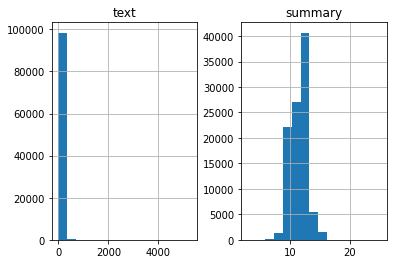

In [31]:
# Determining the maximum lengths for articles and summaries by drawing a distributioin
# graph of their lengths 

article_length = []
summary_length = []

# Finding the length of each article
for sent in cleaned_articles:
    article_length.append(len(sent.split()))

# Finding the length of each summary
for sent in cleaned_summaries:
    summary_length.append(len(sent.split()))

graph_df = pd.DataFrame()

graph_df['text'] = article_length
graph_df['summary'] = summary_length

graph_df.hist(bins=15)
plt.show()

In [34]:
# Check what percentage of summary have 0 to 15 words
count = 0
for row in cleaned_summaries:
    if len(row.split()) <= 15:
        count = count + 1
print("Percentage of summary having less than 15 words: " + str(count/len(cleaned_summaries)))

# Check what percentage of article content have 0 to 600 words
count = 0
for row in cleaned_articles:
    if len(row.split()) <= 600:
        count = count + 1
print("Percentage of article having less than 600 words: " + str(count/len(cleaned_articles)))

Percentage of summary having less than 15 words: 0.9967583775679728
Percentage of article having less than 600 words: 0.9981765873819847


In [35]:
# Initialising the maximum possible length for article content and summary
max_len_article = 600
max_len_summary = 15

# Filtering the articles and summaries
cleaned_articles_np = np.array(cleaned_articles)
cleaned_summaries_np = np.array(cleaned_summaries)

articles = []
summary = []

for i in range(len(cleaned_summaries_np)):
    if len(cleaned_summaries_np[i].split()) <= max_len_summary and len(cleaned_articles_np[i].split()) <= max_len_article:
        articles.append(cleaned_articles_np[i])
        summary.append(cleaned_summaries_np[i])

# Creating a dataframe with the filtered articles and summaries
article_summary_df = pd.DataFrame({
    'article': articles,
    'summary': summary
})
article_summary_df

,article,summary
0,a basic aussie road rule about roundabouts has been stumping drivers across the country the royal automobile club of queensland racq released its weekly quiz this time asking australian motorists ...,_START_ easy roundabout question stumping australians in racq driving quiz _END_
1,a driver has bemused locals in ritzy suburb with their particularly rogue choice of parking spot passer-by on friday spotted silver mazda parked in what would have been difficult position to both ...,_START_ driver behind rogue park in sydney leaves community raging _END_
2,a massive crocodile has snatched small dog from northern queensland beach in bloodcurdling footage shared online captured by onlookers video shows two dogs resting at the edge of calm waters at na...,_START_ heart-stopping video shows moment huge crocodile snatches tiny dog _END_
3,terrifying dashcam footage has captured the moment driver slams on the brakes as young girl darts in front of his car on melbourne street âluckily this driver was alert or this could have ended ...,_START_ dashcam footage shows girl hit by car on melbourne street _END_
4,southern tasmanian locals have flooded social media today with what has been described as the best aurora australis aka southern lights display âeverâ experts say youâll be able to see the l...,_START_ aurora australis strong naked eye southern lights up hobart tasmanian skies _END_
...,...,...
98276,a crpf jawan was on tuesday axed to death with sharp-edged weapons by maoists at local village fair in chhattisgarh insurgency-hit bijapur district as per preliminary information maoists attacked ...,_START_ crpf jawan axed to death by maoists in chhattisgarh _END_
98277,uff yeh the first song from the sonakshi sinha starrer upcoming drama film noor has been released the song has been composed by amaal mallik with vocals by armaan malik and lyrics by manoj muntas...,_START_ first song from sonakshi sinha noor titled uff yeh out _END_
98278,according to reports new version of the 1999 science fiction film the matrix is in development michael jordan will reportedly play the lead role in the film screenwriter zak penn is in talks to wr...,_START_ the matrix film to get reboot reports _END_
98279,a new music video shows rapper snoop dogg aiming toy gun at clown character parodying us president donald trump the video also shows tv airing news conference with the headline ronald klump wants ...,_START_ snoop dogg aims gun at clown dressed as trump in new video _END_


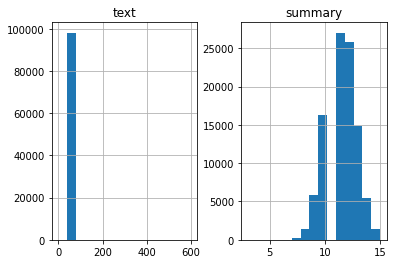

In [36]:
# Determining the maximum lengths for articles and summaries by drawing a distributioin
# graph of their lengths 

article_length = []
summary_length = []

# Finding the length of each article
for sent in articles:
    article_length.append(len(sent.split()))

# Finding the length of each summary
for sent in summary:
    summary_length.append(len(sent.split()))

graph_df = pd.DataFrame()

graph_df['text'] = article_length
graph_df['summary'] = summary_length

graph_df.hist(bins=15)
plt.show()

In [ ]:
article_summary_df.to_csv('/Users/naeeramin/Documents/UTS - 4th semester/ANLP/AT2/articles2.csv')

In [ ]:
article_summary_df = pd.read_csv('/Users/naeeramin/Documents/UTS - 4th semester/ANLP/AT2/articles2.csv')

In [ ]:
article_summary_df

,Unnamed: 0,article,summary
0,50,a powerful us house committee has applied further pressure to tiktok by backing legislation that could give joe biden the power to ban the social video app the house foreign affairs committee vote...,_START_ house committee advances legislation to ban tiktok over security concerns _END_
1,51,rishi sunak has been urged to ban government officials from using tiktok in line with moves by the eu and us amid growing cybersecurity fears over china officials in europe and the us have been to...,_START_ rishi sunak faces calls to ban tiktok use by government officials _END_
2,52,the euâs executive body has banned its thousands of staff from using tiktok over cybersecurity concerns decision the chinese-owned social video app has criticised as âmisguidedâ and based on...,_START_ european commission bans staff using tiktok on work devices over security fears _END_
3,53,your editorial on disinformation 17 february highlights great challenge but of arguably greater importance are the sources of news young people use in 2022 study the reuters institute for the stud...,_START_ what happens if teens get their news from tiktok letter _END_
4,54,a month-long test by social media platform tiktok has resulted in many of its australian users having the sound removed from their videos rendering them unwatchable according to spokesperson for t...,_START_ australian tiktok creators could dump app after month-long test removed sound from videos _END_
...,...,...,...
98226,98276,a crpf jawan was on tuesday axed to death with sharp-edged weapons by maoists at local village fair in chhattisgarh insurgency-hit bijapur district as per preliminary information maoists attacked ...,_START_ crpf jawan axed to death by maoists in chhattisgarh _END_
98227,98277,uff yeh the first song from the sonakshi sinha starrer upcoming drama film noor has been released the song has been composed by amaal mallik with vocals by armaan malik and lyrics by manoj muntas...,_START_ first song from sonakshi sinha noor titled uff yeh out _END_
98228,98278,according to reports new version of the 1999 science fiction film the matrix is in development michael jordan will reportedly play the lead role in the film screenwriter zak penn is in talks to wr...,_START_ the matrix film to get reboot reports _END_
98229,98279,a new music video shows rapper snoop dogg aiming toy gun at clown character parodying us president donald trump the video also shows tv airing news conference with the headline ronald klump wants ...,_START_ snoop dogg aims gun at clown dressed as trump in new video _END_


In [ ]:
# Add sostok and eostok

article_summary_df['summary'] = article_summary_df['summary'].apply(lambda x: 'sostok ' + x + ' eostok')

Modelling

In [ ]:
!pip install keras
!pip install tensorflow
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from keras import backend as K 
from numpy import *
import numpy as np
import pandas as pd 
import re
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Attention
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [ ]:
# Holding out first 50 lines of the dataset as unknown data
hold_out_test_set = article_summary_df[:50]
article_summary_df = article_summary_df[:20000]

In [ ]:
# Splitting the data into train and test sets
train_x, test_x, train_y, test_y = train_test_split( 
    np.array(article_summary_df['article']),
    np.array(article_summary_df["summary"]),
    test_size=0.1,
    random_state=0,
    shuffle=True,
)

In [ ]:
# Preparing a tokenizer for article data
article_tokenizer = Tokenizer()
article_tokenizer.fit_on_texts(list(train_x)) 

In [ ]:
# Finding rare words in articles
count = 0
rare_count = 0
for key, value in article_tokenizer.word_counts.items():
    count += 1
    if value < 5:
        rare_count += 1

In [ ]:
# Initialising the maximum possible length for article content and summary
max_len_article = 600
max_len_summary = 15


In [ ]:
# Preparing a tokenizer by not considering the rare words
article_tokenizer = Tokenizer(num_words = count - rare_count) 
article_tokenizer.fit_on_texts(list(train_x))

# Converting text sequences to integer sequences
train_x = article_tokenizer.texts_to_sequences(train_x)
test_x = article_tokenizer.texts_to_sequences(test_x)

# padding zero to maximum length
train_x = pad_sequences(train_x, maxlen=max_len_article, padding='post')
test_x = pad_sequences(test_x, maxlen=max_len_article, padding='post')

x_vocab_size = len(article_tokenizer.word_index) + 1

In [ ]:

# Preparing a tokenizer for summary data
summary_tokenizer = Tokenizer()
summary_tokenizer.fit_on_texts(list(train_y))

In [ ]:
# Finding rare words in summaries
count = 0
rare_count = 0
for key, value in summary_tokenizer.word_counts.items():
    count += 1
    if value < 5:
        rare_count += 1

In [ ]:
# Preparing a tokenizer by not considering the rare words
summary_tokenizer = Tokenizer(num_words = count - rare_count) 
summary_tokenizer.fit_on_texts(list(train_y))

# Converting text sequences to integer sequences
train_y = summary_tokenizer.texts_to_sequences(train_y)
test_y = summary_tokenizer.texts_to_sequences(test_y)

# padding zero to maximum length
train_y = pad_sequences(train_y, maxlen=max_len_summary, padding='post')
test_y = pad_sequences(test_y, maxlen=max_len_summary, padding='post')

y_vocab_size = len(summary_tokenizer.word_index) + 1
# Reference: https://www.analyticsvidhya.com/blog/2019/06/comprehensive-guide-text-summarization-using-deep-learning-python/

In [ ]:
print(x_vocab_size)
print(y_vocab_size)

39797
17922


In [ ]:
latent_dim = 300
embedding_dim=200

# Encoder
inputs = Input(shape=(max_len_article,))

#embedding layer
embedding_layer =  Embedding(x_vocab_size, embedding_dim,trainable=True)(inputs)

#encoder lstm 1
lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = lstm1(embedding_layer)

#encoder lstm 2
lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = lstm2(encoder_output1)

#encoder lstm 3
lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_embedding = Embedding(y_vocab_size, embedding_dim,trainable=True)
dec_emb = dec_embedding(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_vocab_size, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model 
model = Model([inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 600)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 600, 200)             7959400   ['input_1[0][0]']             
                                                                                                  
 lstm (LSTM)                 [(None, 600, 300),           601200    ['embedding[0][0]']           
                              (None, 300),                                                        
                              (None, 300)]                                                        
                                                                                              

In [ ]:
# Compiling the model
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [ ]:
fitted_model = model.fit(
    [train_x,train_y[:,:-1]], 
    train_y.reshape(train_y.shape[0],train_y.shape[1], 1)[:,1:],
    epochs=20,
    callbacks=[es],
    batch_size=128, 
    validation_data=([test_x,test_y[:,:-1]], test_y.reshape(test_y.shape[0],test_y.shape[1], 1)[:,1:])
    )

Epoch 1/20
141/141 [==============================] - 2260s 16s/step - loss: 5.1873 - val_loss: 4.6709
Epoch 2/20
141/141 [==============================] - 2310s 16s/step - loss: 4.6891 - val_loss: 4.5460
Epoch 3/20
141/141 [==============================] - 2344s 17s/step - loss: 4.6000 - val_loss: 4.4835
Epoch 4/20
141/141 [==============================] - 2214s 16s/step - loss: 4.5258 - val_loss: 4.4304
Epoch 5/20
141/141 [==============================] - 2318s 16s/step - loss: 4.4489 - val_loss: 4.3819
Epoch 6/20
106/141 [=====================>........] - ETA: 8:42 - loss: 4.3721

KeyboardInterrupt: 

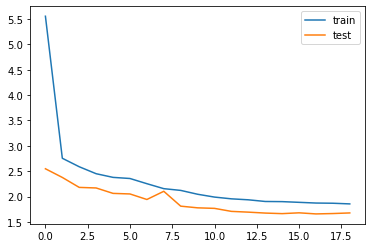

In [ ]:
# Plotting the train and val loss
plt.plot(fitted_model.history['loss'], label='train') 
plt.plot(fitted_model.history['val_loss'], label='test') 
plt.legend() 
plt.show()

In [ ]:
# Building reverse word index for converting indices to word for both articles and summaries
reverse_article_word_index = article_tokenizer.index_word
reverse_summary_word_index = summary_tokenizer.index_word

summary_word_index=summary_tokenizer.word_index

In [ ]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_article,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_embedding(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])
# Reference: https://www.kaggle.com/code/sandeepbhogaraju/text-summarization-with-seq2seq-model

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = summary_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_summary_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_len_summary-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence
# Reference: https://www.kaggle.com/code/sandeepbhogaraju/text-summarization-with-seq2seq-model

In [ ]:
# Function to convert sequence to summary
def sequence_to_summary(text):
    result = ''
    for i in text:
      if((i!=0 and i!=summary_word_index['sostok']) and i!=summary_word_index['eostok']):
        result = result + reverse_summary_word_index[i] + ' '
    return result

# Function to convert sequence to articles
def sequence_to_articles(text):
    result = ''
    for i in text:
      if(i!=0):
        result = result + reverse_article_word_index[i] + ' '
    return result

In [ ]:
for i in range(19):
    print("Review:",sequence_to_articles(test_x[i]))
    print("Original summary:",sequence_to_summary(test_y[i]))
    print("Predicted summary:",decode_sequence(test_x[i].reshape(1,max_len_article)))
    print("\n")

Review: jammu and kashmir pal has said that he feels even if his life and urged to return to the added his was in the process of new for the of terrorists he further the security forces in activities in the state 
Original summary: start i even if loses his life end 
1/1 [==============================] - 0s 20ms/step
Predicted summary:  start to to to end


Review: city 5 0 in cup fourth round on saturday to record their victory across all the for city in the while the four came in the second half including an own by long city have now scored 30 in seven in 2019 
Original summary: start man 5 in to win end 
1/1 [==============================] - 0s 18ms/step
Predicted summary:  start to to to end


Review: a 2017 letter by investors to co founder and then ceo has now become public in which the investors told they need and new ceo the public is that and the investors had said you need to immediately and as ceo was told 
Original summary: start need ceo in end 
1/1 [====================

In [ ]:
# Predicting summaries for the scraped articles
test_data = pd.DataFrame({
    'article': scraped_data['article'],
    'summary': scraped_data['headline'],
    'url': scraped_data['url']
})


In [ ]:
# Creating generator objects for articles for cleaning text
test_article_obj = clean_text(test_data['article'])
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser'])

# Getting a list of articles after processing them using the Spacy library
test_cleaned_articles = [str(doc) for doc in nlp.pipe(test_article_obj, batch_size=5000)]

In [ ]:
# Preparing a tokenizer for article data
article_tokenizer = Tokenizer()
article_tokenizer.fit_on_texts(list(test_cleaned_articles)) 

# Converting text sequences to integer sequences
test_unseen_articles = article_tokenizer.texts_to_sequences(test_cleaned_articles)

# padding zero to maximum length
test_unseen_articles = pad_sequences(test_unseen_articles, maxlen=max_len_article, padding='post')

In [ ]:
test_predicted_summaries = []
for i in range(len(test_unseen_articles)):
    test_predicted_summaries.append(
        decode_sequence(test_unseen_articles[i].reshape(1,max_len_article)))

1/1 [==============================] - 0s 21ms/step
[6.9608390e-08 4.4261100e-10 9.9993539e-01 ... 5.6180770e-17 5.9686521e-17
 5.5144393e-17]
2
1/1 [==============================] - 0s 21ms/step
[3.6985417e-05 3.0053649e-04 2.7280426e-04 ... 5.4607830e-07 5.4527271e-07
 5.4297084e-07]
35
1/1 [==============================] - 0s 21ms/step
[3.1025209e-07 6.8505724e-05 3.5458524e-04 ... 4.4066539e-07 4.3558799e-07
 4.4185964e-07]
122
1/1 [==============================] - 0s 24ms/step
[2.4590202e-06 9.2107832e-05 7.9324789e-04 ... 5.4069659e-07 5.2066167e-07
 5.2097010e-07]
22
1/1 [==============================] - 0s 20ms/step
[2.4885553e-06 1.7415639e-04 7.5588134e-05 ... 1.2691739e-06 1.1953639e-06
 1.2573843e-06]
5
1/1 [==============================] - 0s 20ms/step
[1.2300369e-06 3.8888666e-04 2.2533005e-03 ... 2.6620805e-07 2.6595430e-07
 2.6298923e-07]
22
1/1 [==============================] - 0s 26ms/step
[4.9303952e-07 3.3055589e-04 7.0899652e-05 ... 1.0983341e-06 1.0057545e-0

In [ ]:
test_data['predicted_summaries'] = test_predicted_summaries

In [ ]:
test_data.to_csv('./predicted_summaries.csv')

In [ ]:
test_data

,article,summary,url,predicted_summaries
0,A shed supplier on the Sunshine Coast has become the latest casualty to join a spate of companies in the sector which have gone bankrupt in recent months.\nMooloolaba-based business Transportable ...,Transportable Shade Sheds collapse: Customer furious after learning Sunshine Coast company owes $1.3 million,https://www.news.com.au/finance/business/other-industries/devastated-angry-customers-owed-thousands-following-transportable-shade-sheds-collapse/news-story/1aafe6f9b4f2ad5af1b655ac4bc2596c,start i don be to be in india in india end
1,"At just 17 years old, fashion-loving Argylica Conditsis took $1000 she had saved from her part-time Pizza Hut job and invested it in her âhobbyâ.\nThe Sydney teen had a âcrazy ideaâ to sel...",How Argylica Conditsis turned Babyboo Fashion into $60m empire,https://www.news.com.au/finance/business/retail/sydney-woman-turns-1000-pizza-hut-earnings-into-60-million-fashion-empire-in-just-12-years/news-story/b2f4af56e67430fac8a4c5a1f3ce66b6,start i don be to be in india in india end
2,"A basic Aussie road rule about roundabouts has been stumping drivers across the country. \nThe Royal Automobile Club of Queensland (RACQ) released its weekly quiz, this time asking Australian moto...",Easy roundabout question stumping Australians in RACQ driving quiz,https://www.news.com.au/technology/motoring/on-the-road/easy-roundabout-question-stumping-aussies/news-story/ecbd6b92139730fa1a1d912a6e238013,start i don be to be in india in india end
3,A driver has bemused locals in a ritzy suburb with their particularly rogue choice of parking spot. \nA passer-by on Friday spotted a silver Mazda parked in what would have been a difficult positi...,Driver behind rogue park in Sydney leaves community raging,https://www.news.com.au/technology/motoring/on-the-road/community-blasts-drivers-bizarre-parking-display-in-ritzy-suburb/news-story/6731bff0399e45d67a24af59a83f99a7,start i don be to be in india in india end
4,"A massive crocodile has snatched a small dog from a northern Queensland beach in bloodcurdling footage shared online.\nCaptured by onlookers, a video shows two dogs resting at the edge of calm wat...",Heart-stopping video shows moment huge crocodile snatches tiny dog,https://www.news.com.au/technology/science/animals/heartstopping-video-shows-moment-huge-crocodile-snatches-tiny-dog/news-story/d1ee0a84c77769037698b342f00a747f,start i don be to be in india in india end
...,...,...,...,...
310,"Great news, holiday shoppers: you can finally get your hands on a 100% authentic, 3ft-tall statue of the Twitter bird. An online auction next month will feature hundreds of the companyâs âsurp...",Twitter office oddities go up for auction â from bird statues to rotisserie ovens,https://www.theguardian.com/technology/2022/dec/13/twitter-hq-office-auction-items,start i don be to be in india in india end
311,"The threat model of a social network is complex. Your security team has to deal with conventional hacking attacks, as hostile actors probe for technical errors in your apps and servers that they c...",TechScape: I read Elon Muskâs âTwitter Filesâ so you donât have to,https://www.theguardian.com/technology/2022/dec/13/techscape-twitter-files-elon-musk,start i don be to be in india in india end
312,More than 30 million users are expected to leave Twitter over the next two years as concerns mount over technical issues and the proliferation of offensive content after Elon Muskâs $44bn takeov...,Twitter âto lose 32m users in two years after Elon Musk takeoverâ,https://www.theguardian.com/technology/2022/dec/13/twitter-lose-users-elon-musk-takeover-hate-speech,start i don be to be in india in india end
313,"Elon Muskâs Twitter abruptly dissolved its Trust and Safety Council on Monday night, just moments before it was scheduled to meet with company representatives. The council was an advisory group ...",Twitter abruptly dissolves safety council moments befo